In [1]:
import numpy as np
import numpy.linalg as LA

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
import time
from datetime import datetime

from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, cross_validate 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from statistics import mean

import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.tools.eval_measures import mse, rmse, meanabs, stde
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.seasonal import seasonal_decompose

from dateutil.parser import parse

from scipy.stats import pearsonr, spearmanr, kendalltau, poisson, bernoulli

## Data Analysis

In [2]:
url = "/content/drive/Shareddrives/Ciencia de datos y asi/Data/2012_2019_PlatteRiverWeir_features_merged_all.csv"
df = pd.read_csv(url)
df.head()

,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,width,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
x = pd.to_datetime(df['SensorTime'], format="%Y-%m-%d %H:%M:%S")

time = []
for day in x:
  time.append(day.timestamp())
  
df["SensorTimeSeconds"] = time
df["datetime"] = x


In [4]:
spring = df[((pd.to_datetime(df['SensorTime']).dt.day >= 21) & (pd.to_datetime(df['SensorTime']).dt.month == 3)) | ((pd.to_datetime(df['SensorTime']).dt.month >= 4) & (pd.to_datetime(df['SensorTime']).dt.month <= 5)) | ((pd.to_datetime(df['SensorTime']).dt.day <= 20) & (pd.to_datetime(df['SensorTime']).dt.month == 6))]
spring_idx = spring.index

summer = df[((pd.to_datetime(df['SensorTime']).dt.day >= 21) & (pd.to_datetime(df['SensorTime']).dt.month == 6)) | ((pd.to_datetime(df['SensorTime']).dt.month >= 7) & (pd.to_datetime(df['SensorTime']).dt.month <= 8)) | ((pd.to_datetime(df['SensorTime']).dt.day <= 22) & (pd.to_datetime(df['SensorTime']).dt.month == 9))]
summer_idx = summer.index


autumn = df[((pd.to_datetime(df['SensorTime']).dt.day >= 23) & (pd.to_datetime(df['SensorTime']).dt.month == 9)) | ((pd.to_datetime(df['SensorTime']).dt.month >= 10) & (pd.to_datetime(df['SensorTime']).dt.month <= 11)) | ((pd.to_datetime(df['SensorTime']).dt.day <= 20) & (pd.to_datetime(df['SensorTime']).dt.month == 12))]
autumn_idx = autumn.index


winter = df[((pd.to_datetime(df['SensorTime']).dt.day >= 21) & (pd.to_datetime(df['SensorTime']).dt.month == 12)) | ((pd.to_datetime(df['SensorTime']).dt.month >= 1) & (pd.to_datetime(df['SensorTime']).dt.month <= 2)) | ((pd.to_datetime(df['SensorTime']).dt.day <= 20) & (pd.to_datetime(df['SensorTime']).dt.month == 3))]
winter_idx = winter.index

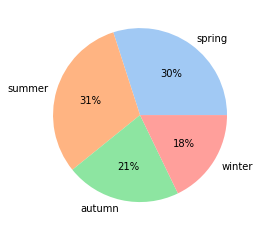

In [5]:
data = [spring.size, summer.size, autumn.size, winter.size]
labels = ['spring', 'summer', 'autumn', 'winter']

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [6]:
data

[768966, 791475, 547780, 457378]

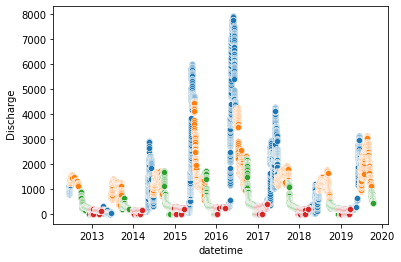

In [7]:
sns.scatterplot(data=spring, x="datetime", y=" Discharge")
sns.scatterplot(data=summer, x="datetime", y=" Discharge")
sns.scatterplot(data=autumn, x="datetime", y=" Discharge")
sns.scatterplot(data=winter, x="datetime", y=" Discharge")

In [8]:
scaler = StandardScaler()

In [9]:
df_train = df[df['datetime'].dt.year < 2018].reset_index().copy()
df_test = df[df['datetime'].dt.year >= 2018].reset_index().copy()

#Spring

## Season Analysis

### Variables

In [10]:
spring_Xtrain = df_train[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
spring_Ytrain = df_train[' Discharge']

spring_Xtest = df_test[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
spring_Ytest = df_test[' Discharge']

scaled_spring_Xtrain = scaler.fit_transform(spring_Xtrain)
scaled_spring_Xtest = scaler.fit_transform(spring_Xtest)

#scaled_spring_y = scaler.fit_transform(spring_y)

spring_Xtrain = pd.DataFrame(scaled_spring_Xtrain, columns=spring_Xtrain.columns)
spring_Xtest = pd.DataFrame(scaled_spring_Xtest, columns=spring_Xtest.columns)

#spring_X = sm.add_constant(spring_X)
#spring_y = pd.DataFrame(scaled_spring_y, index=spring_idx, columns=spring_y.columns)

### Correlation

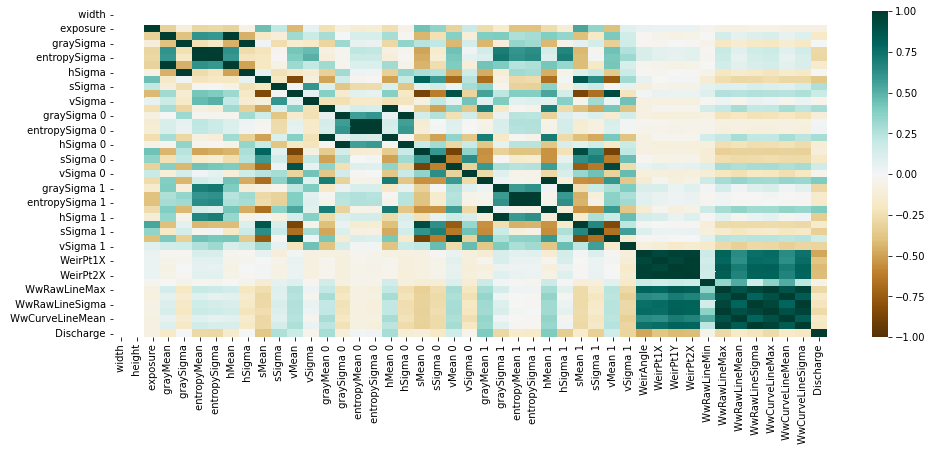

In [ ]:
spring = pd.concat([spring_Xtrain, spring_Ytrain], axis=1)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(spring.corr(), vmin=-1, vmax=1, cmap='BrBG')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Text(0.5, 1.0, 'Spearman correlation')

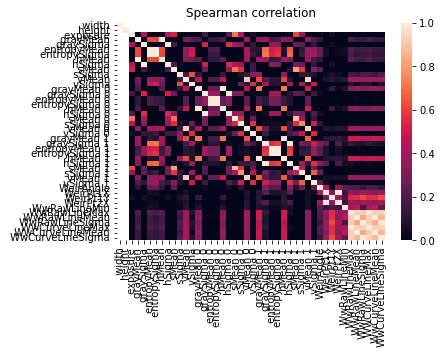

In [ ]:
nvar = spring_Xtrain.columns.size
corr = spring_Xtrain.corr()
cov = spring_Xtrain.cov(ddof=1)

rho_pval = np.zeros((nvar, nvar))
rho = np.eye(nvar)

for i in range(nvar):
    for j in range(i+1, nvar):
        r = spearmanr(spring_Xtrain.iloc[:, i], spring_Xtrain.iloc[:, j])
        rho[i, j] = r[0]
        rho[j, i] = r[0]
        
        rho_pval[i, j] = r[1]
        rho_pval[j, i] = r[1]

sns.heatmap(rho, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0, vmax=1)
plt.title("Spearman correlation")

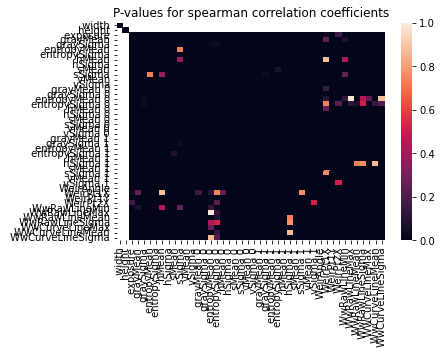

In [ ]:
plt.title("P-values for spearman correlation coefficients")
sns.heatmap(rho_pval, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0, vmax=1)

In [ ]:
det = LA.det(cov)
det

0.0

### PCA

In [ ]:
pca = PCA(n_components = nvar)
pca.fit(spring_Xtrain)

PCA(n_components=44)

Varianza explicada acumulada:
 [0.27802931 0.45589612 0.59631991 0.69249894 0.75541449 0.79918572
 0.83288104 0.85977135 0.88146397 0.8996249  0.91357449 0.92651162
 0.93834999 0.94973869 0.95918877 0.96669573 0.97309259 0.97804614
 0.98250623 0.98656924 0.99060362 0.99335036 0.99518576 0.99647735
 0.99755742 0.99835191 0.99893224 0.99928841 0.99958941 0.99970095
 0.99978498 0.99985002 0.99989436 0.99992642 0.99994728 0.99996425
 0.99997944 0.99998997 0.99999431 0.9999984  0.99999999 1.
 1.         1.        ]


Text(0.5, 1.0, 'Número de componentes vs porcentaje de varianza explicada')

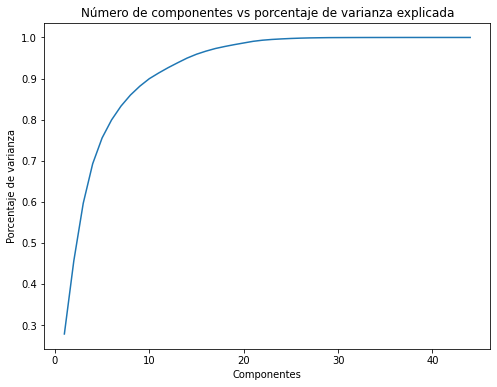

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

print("Varianza explicada acumulada:\n", cumulative_variance)

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 45, 1), cumulative_variance)
plt.xlabel("Componentes")
plt.ylabel("Porcentaje de varianza")
plt.title("Número de componentes vs porcentaje de varianza explicada")

In [ ]:
# pca = PCA(n_components = 20)
# pca.fit(xnew)

# scores = pca.transform(xnew)

## Models

### Linear Regression

In [11]:
modeLr = LinearRegression()
resLr = modeLr.fit(spring_Xtrain, spring_Ytrain)

In [12]:
y_pred = resLr.predict(spring_Xtest)
res = spring_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(spring_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(spring_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(spring_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(spring_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  2056335.6655546962
RSMSE:  1433.9929098690468
MAE:  839.5650984153505
Error estandar:  1390.8540131850573


### Ridge Regression

In [13]:
ridgeMod = Ridge(alpha=1.0)
resRid = ridgeMod.fit(spring_Xtrain, spring_Ytrain)

In [14]:
y_pred = resRid.predict(spring_Xtest)
res = spring_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(spring_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(spring_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(spring_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(spring_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  527432.1676156112
RSMSE:  726.2452530761294
MAE:  537.5399948105946
Error estandar:  636.5729263374828


### Lasso Regression

In [15]:
lassoMod = Lasso(alpha=1.0)
resLasso = lassoMod.fit(spring_Xtrain, spring_Ytrain)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+08, tolerance: 5.105e+06
  model = cd_fast.enet_coordinate_descent(


In [16]:
y_pred = resLasso.predict(spring_Xtest)
res = spring_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(spring_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(spring_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(spring_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(spring_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  512450.7854377941
RSMSE:  715.8566793973456
MAE:  541.847354591589
Error estandar:  624.6921762568376


### Knn

In [17]:
kMod = KNeighborsRegressor(n_neighbors=75)
resK = kMod.fit(spring_Xtrain, spring_Ytrain)

In [18]:
y_pred = resK.predict(spring_Xtest)
res = spring_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(spring_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(spring_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(spring_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(spring_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  393780.76821470464
RSMSE:  627.5195361219479
MAE:  350.5308620571658
Error estandar:  590.3670132586354


### Decision Tree

In [19]:
dTreeMod = DecisionTreeRegressor(random_state=0)
resTree = dTreeMod.fit(spring_Xtrain, spring_Ytrain)

In [20]:
y_pred = resTree.predict(spring_Xtest)
res = spring_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(spring_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(spring_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(spring_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(spring_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  1015884.1218386474
RSMSE:  1007.9107707722184
MAE:  524.7947871376812
Error estandar:  971.7103837456598


### Random Forest

In [11]:
rForMod = RandomForestRegressor()
rForRes = rForMod.fit(spring_Xtrain, spring_Ytrain)

In [12]:
y_pred = rForRes.predict(spring_Xtest)
res = spring_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(spring_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(spring_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(spring_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(spring_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  346941.7780303232
RSMSE:  589.0176381317654
MAE:  359.61559521437204
Error estandar:  536.6224282477349


Text(0.5, 0, 'Random Forest Feature Importance')

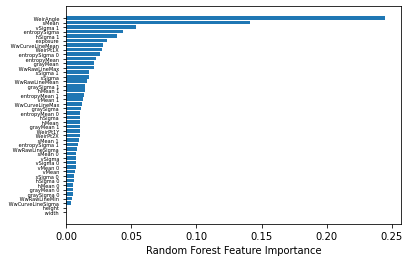

In [14]:
sorted_idx = rForRes.feature_importances_.argsort()
plt.barh(spring_Xtrain.columns[sorted_idx], rForRes.feature_importances_[sorted_idx])
plt.yticks(fontsize=5)
plt.xlabel("Random Forest Feature Importance")

In [15]:
spring_Xtrain.columns[sorted_idx]

Index([' width', ' height', ' WwCurveLineSigma', ' WwRawLineMin',
       ' graySigma 0', ' grayMean 0', ' hMean 0', ' hSigma 0', ' sSigma 0',
       ' vMean', ' vMean 0', ' vSigma 0', ' vSigma', ' sMean 0',
       ' WwRawLineSigma', ' entropySigma 1', ' sMean 1', ' WeirPt2X',
       ' WeirPt1Y', ' grayMean 1', ' hMean', ' hSigma', ' entropyMean 0',
       ' graySigma', ' WwCurveLineMax', ' vMean 1', ' entropyMean 1',
       ' hMean 1', ' graySigma 1', ' WwRawLineMean', ' sSigma', ' sSigma 1',
       ' WwRawLineMax', ' grayMean', ' entropyMean', ' entropySigma 0',
       ' WeirPt1X', ' WwCurveLineMean', ' exposure', ' hSigma 1',
       ' entropySigma', ' vSigma 1', ' sMean', ' WeirAngle'],
      dtype='object')

# Summer

## Season Analysis

### Variables

In [23]:
summer_Xtrain = df_train[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
summer_Ytrain = df_train[' Discharge']

summer_Xtest = df_test[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
summer_Ytest = df_test[' Discharge']

scaled_summer_Xtrain = scaler.fit_transform(summer_Xtrain)
scaled_summer_Xtest = scaler.fit_transform(summer_Xtest)

#scaled_summer_y = scaler.fit_transform(summer_y)

summer_Xtrain = pd.DataFrame(scaled_summer_Xtrain, columns=summer_Xtrain.columns)
summer_Xtest = pd.DataFrame(scaled_summer_Xtest, columns=summer_Xtest.columns)

#summer_X = sm.add_constant(summer_X)
#summer_y = pd.DataFrame(scaled_summer_y, index=summer_idx, columns=summer_y.columns)

### Correlation

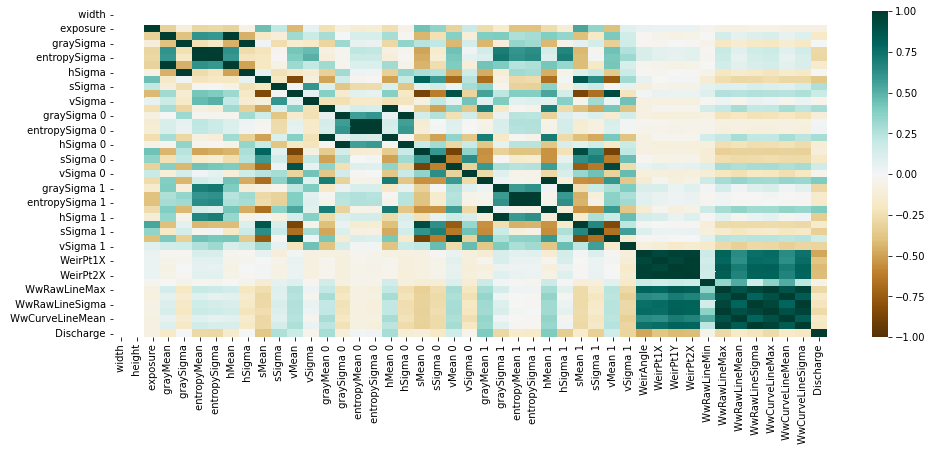

In [ ]:
summer = pd.concat([summer_Xtrain, summer_Ytrain], axis=1)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(summer.corr(), vmin=-1, vmax=1, cmap='BrBG')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Text(0.5, 1.0, 'Spearman correlation')

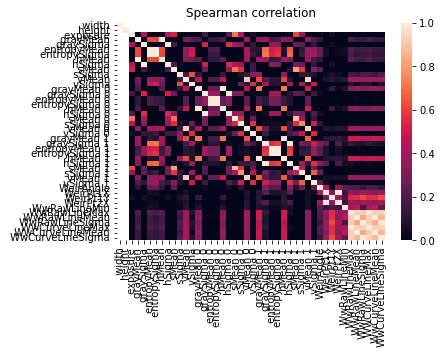

In [ ]:
nvar = summer_Xtrain.columns.size
corr = summer_Xtrain.corr()
cov = summer_Xtrain.cov(ddof=1)

rho_pval = np.zeros((nvar, nvar))
rho = np.eye(nvar)

for i in range(nvar):
    for j in range(i+1, nvar):
        r = spearmanr(summer_Xtrain.iloc[:, i], summer_Xtrain.iloc[:, j])
        rho[i, j] = r[0]
        rho[j, i] = r[0]
        
        rho_pval[i, j] = r[1]
        rho_pval[j, i] = r[1]

sns.heatmap(rho, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0, vmax=1)
plt.title("Spearman correlation")

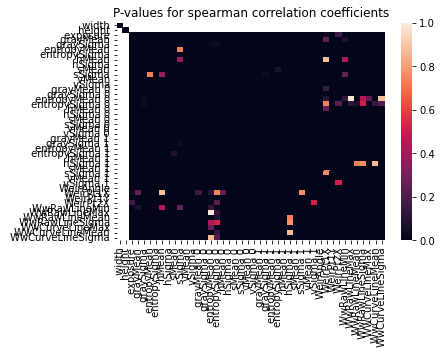

In [ ]:
plt.title("P-values for spearman correlation coefficients")
sns.heatmap(rho_pval, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0, vmax=1)

In [ ]:
det = LA.det(cov)
det

0.0

### PCA

In [ ]:
pca = PCA(n_components = nvar)
pca.fit(summer_Xtrain)

PCA(n_components=44)

Varianza explicada acumulada:
 [0.27802931 0.45589612 0.59631991 0.69249894 0.75541449 0.79918572
 0.83288104 0.85977135 0.88146397 0.8996249  0.91357449 0.92651162
 0.93834999 0.94973869 0.95918877 0.96669573 0.97309259 0.97804614
 0.98250623 0.98656924 0.99060362 0.99335036 0.99518576 0.99647735
 0.99755742 0.99835191 0.99893224 0.99928841 0.99958941 0.99970095
 0.99978498 0.99985002 0.99989436 0.99992642 0.99994728 0.99996425
 0.99997944 0.99998997 0.99999431 0.9999984  0.99999999 1.
 1.         1.        ]


Text(0.5, 1.0, 'Número de componentes vs porcentaje de varianza explicada')

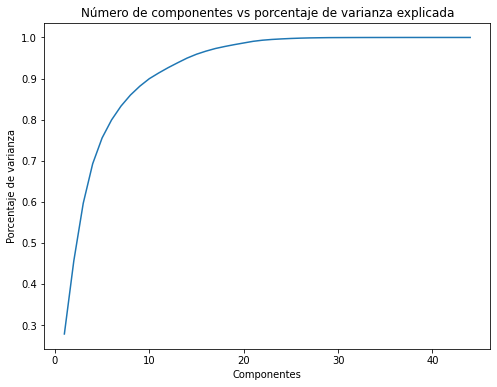

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

print("Varianza explicada acumulada:\n", cumulative_variance)

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 45, 1), cumulative_variance)
plt.xlabel("Componentes")
plt.ylabel("Porcentaje de varianza")
plt.title("Número de componentes vs porcentaje de varianza explicada")

In [ ]:
# pca = PCA(n_components = 20)
# pca.fit(xnew)

# scores = pca.transform(xnew)

## Models

### Linear Regression

In [24]:
modeLr = LinearRegression()
resLr = modeLr.fit(summer_Xtrain, summer_Ytrain)

In [25]:
y_pred = resLr.predict(summer_Xtest)
res = summer_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(summer_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(summer_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(summer_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(summer_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  2056335.6655546962
RSMSE:  1433.9929098690468
MAE:  839.5650984153505
Error estandar:  1390.8540131850573


### Ridge Regression

In [26]:
ridgeMod = Ridge(alpha=1.0)
resRid = ridgeMod.fit(summer_Xtrain, summer_Ytrain)

In [27]:
y_pred = resRid.predict(summer_Xtest)
res = summer_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(summer_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(summer_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(summer_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(summer_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  527432.1676156112
RSMSE:  726.2452530761294
MAE:  537.5399948105946
Error estandar:  636.5729263374828


### Lasso Regression

In [28]:
lassoMod = Lasso(alpha=1.0)
resLasso = lassoMod.fit(summer_Xtrain, summer_Ytrain)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+08, tolerance: 5.105e+06
  model = cd_fast.enet_coordinate_descent(


In [29]:
y_pred = resLasso.predict(summer_Xtest)
res = summer_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(summer_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(summer_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(summer_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(summer_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  512450.7854377941
RSMSE:  715.8566793973456
MAE:  541.847354591589
Error estandar:  624.6921762568376


### Knn

In [30]:
kMod = KNeighborsRegressor(n_neighbors=75)
resK = kMod.fit(summer_Xtrain, summer_Ytrain)

In [31]:
y_pred = resK.predict(summer_Xtest)
res = summer_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(summer_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(summer_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(summer_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(summer_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  393780.76821470464
RSMSE:  627.5195361219479
MAE:  350.5308620571658
Error estandar:  590.3670132586354


### Decision Tree

In [32]:
dTreeMod = DecisionTreeRegressor(random_state=0)
resTree = dTreeMod.fit(summer_Xtrain, summer_Ytrain)

In [33]:
y_pred = resTree.predict(summer_Xtest)
res = summer_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(summer_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(summer_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(summer_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(summer_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  1015884.1218386474
RSMSE:  1007.9107707722184
MAE:  524.7947871376812
Error estandar:  971.7103837456598


### Random Forest

In [34]:
rForMod = RandomForestRegressor()
rForRes = rForMod.fit(summer_Xtrain, summer_Ytrain)

In [35]:
y_pred = rForRes.predict(summer_Xtest)
res = summer_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(summer_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(summer_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(summer_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(summer_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  343552.70591969584
RSMSE:  586.1336928719385
MAE:  358.25388140096624
Error estandar:  531.2415254441464


# Autumn

## Season Analysis

### Variables

In [36]:
autumn_Xtrain = df_train[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
autumn_Ytrain = df_train[' Discharge']

autumn_Xtest = df_test[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
autumn_Ytest = df_test[' Discharge']

scaled_autumn_Xtrain = scaler.fit_transform(autumn_Xtrain)
scaled_autumn_Xtest = scaler.fit_transform(autumn_Xtest)

#scaled_autumn_y = scaler.fit_transform(autumn_y)

autumn_Xtrain = pd.DataFrame(scaled_autumn_Xtrain, columns=autumn_Xtrain.columns)
autumn_Xtest = pd.DataFrame(scaled_autumn_Xtest, columns=autumn_Xtest.columns)

#autumn_X = sm.add_constant(autumn_X)
#autumn_y = pd.DataFrame(scaled_autumn_y, index=autumn_idx, columns=autumn_y.columns)

### Correlation

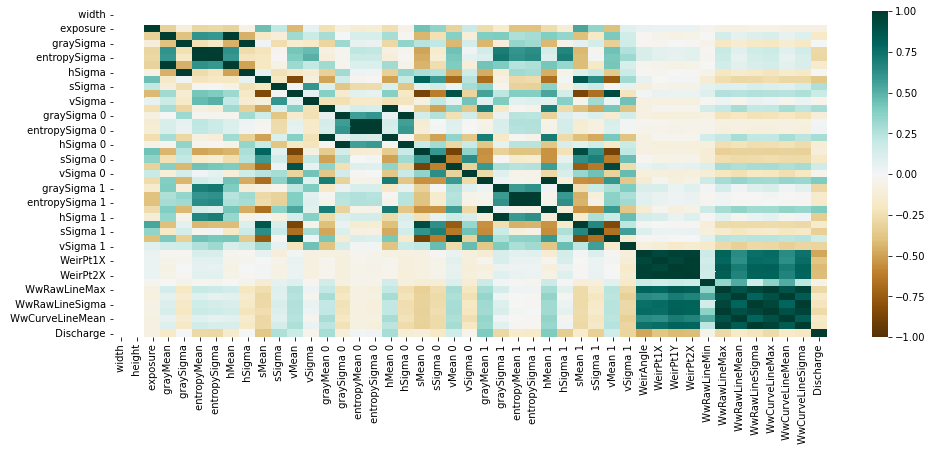

In [ ]:
autumn = pd.concat([autumn_Xtrain, autumn_Ytrain], axis=1)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(autumn.corr(), vmin=-1, vmax=1, cmap='BrBG')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Text(0.5, 1.0, 'Spearman correlation')

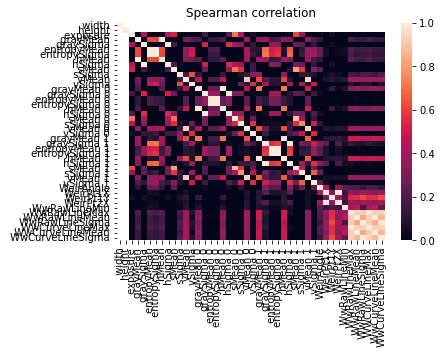

In [ ]:
nvar = autumn_Xtrain.columns.size
corr = autumn_Xtrain.corr()
cov = autumn_Xtrain.cov(ddof=1)

rho_pval = np.zeros((nvar, nvar))
rho = np.eye(nvar)

for i in range(nvar):
    for j in range(i+1, nvar):
        r = spearmanr(autumn_Xtrain.iloc[:, i], autumn_Xtrain.iloc[:, j])
        rho[i, j] = r[0]
        rho[j, i] = r[0]
        
        rho_pval[i, j] = r[1]
        rho_pval[j, i] = r[1]

sns.heatmap(rho, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0, vmax=1)
plt.title("Spearman correlation")

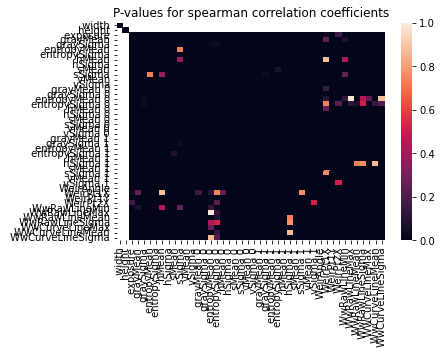

In [ ]:
plt.title("P-values for spearman correlation coefficients")
sns.heatmap(rho_pval, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0, vmax=1)

In [ ]:
det = LA.det(cov)
det

0.0

### PCA

In [ ]:
pca = PCA(n_components = nvar)
pca.fit(autumn_Xtrain)

PCA(n_components=44)

Varianza explicada acumulada:
 [0.27802931 0.45589612 0.59631991 0.69249894 0.75541449 0.79918572
 0.83288104 0.85977135 0.88146397 0.8996249  0.91357449 0.92651162
 0.93834999 0.94973869 0.95918877 0.96669573 0.97309259 0.97804614
 0.98250623 0.98656924 0.99060362 0.99335036 0.99518576 0.99647735
 0.99755742 0.99835191 0.99893224 0.99928841 0.99958941 0.99970095
 0.99978498 0.99985002 0.99989436 0.99992642 0.99994728 0.99996425
 0.99997944 0.99998997 0.99999431 0.9999984  0.99999999 1.
 1.         1.        ]


Text(0.5, 1.0, 'Número de componentes vs porcentaje de varianza explicada')

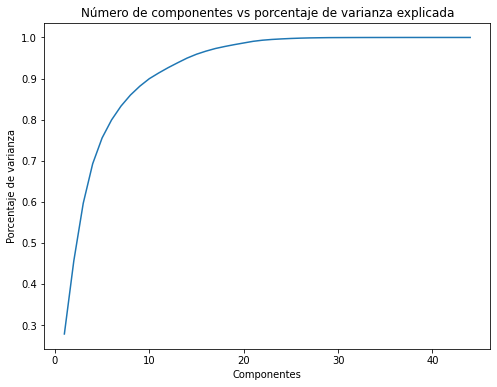

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

print("Varianza explicada acumulada:\n", cumulative_variance)

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 45, 1), cumulative_variance)
plt.xlabel("Componentes")
plt.ylabel("Porcentaje de varianza")
plt.title("Número de componentes vs porcentaje de varianza explicada")

In [ ]:
# pca = PCA(n_components = 20)
# pca.fit(xnew)

# scores = pca.transform(xnew)

## Models

### Linear Regression

In [37]:
modeLr = LinearRegression()
resLr = modeLr.fit(autumn_Xtrain, autumn_Ytrain)

In [38]:
y_pred = resLr.predict(autumn_Xtest)
res = autumn_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(autumn_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(autumn_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(autumn_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(autumn_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  2056335.6655546962
RSMSE:  1433.9929098690468
MAE:  839.5650984153505
Error estandar:  1390.8540131850573


### Ridge Regression

In [39]:
ridgeMod = Ridge(alpha=1.0)
resRid = ridgeMod.fit(autumn_Xtrain, autumn_Ytrain)

In [40]:
y_pred = resRid.predict(autumn_Xtest)
res = autumn_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(autumn_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(autumn_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(autumn_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(autumn_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  527432.1676156112
RSMSE:  726.2452530761294
MAE:  537.5399948105946
Error estandar:  636.5729263374828


### Lasso Regression

In [41]:
lassoMod = Lasso(alpha=1.0)
resLasso = lassoMod.fit(autumn_Xtrain, autumn_Ytrain)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+08, tolerance: 5.105e+06
  model = cd_fast.enet_coordinate_descent(


In [42]:
y_pred = resLasso.predict(autumn_Xtest)
res = autumn_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(autumn_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(autumn_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(autumn_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(autumn_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  512450.7854377941
RSMSE:  715.8566793973456
MAE:  541.847354591589
Error estandar:  624.6921762568376


### Knn

In [43]:
kMod = KNeighborsRegressor(n_neighbors=75)
resK = kMod.fit(autumn_Xtrain, autumn_Ytrain)

In [44]:
y_pred = resK.predict(autumn_Xtest)
res = autumn_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(autumn_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(autumn_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(autumn_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(autumn_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  393780.76821470464
RSMSE:  627.5195361219479
MAE:  350.5308620571658
Error estandar:  590.3670132586354


### Decision Tree

In [45]:
dTreeMod = DecisionTreeRegressor(random_state=0)
resTree = dTreeMod.fit(autumn_Xtrain, autumn_Ytrain)

In [46]:
y_pred = resTree.predict(autumn_Xtest)
res = autumn_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(autumn_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(autumn_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(autumn_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(autumn_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  1015884.1218386474
RSMSE:  1007.9107707722184
MAE:  524.7947871376812
Error estandar:  971.7103837456598


### Random Forest

In [47]:
rForMod = RandomForestRegressor()
rForRes = rForMod.fit(autumn_Xtrain, autumn_Ytrain)

In [48]:
y_pred = rForRes.predict(autumn_Xtest)
res = autumn_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(autumn_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(autumn_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(autumn_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(autumn_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  333237.33537317114
RSMSE:  577.2671265308385
MAE:  349.8400140625
Error estandar:  528.7282486797002


# Winter

## Season Analysis

### Variables

In [49]:
winter_Xtrain = df_train[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
winter_Ytrain = df_train[' Discharge']

winter_Xtest = df_test[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
winter_Ytest = df_test[' Discharge']

scaled_winter_Xtrain = scaler.fit_transform(winter_Xtrain)
scaled_winter_Xtest = scaler.fit_transform(winter_Xtest)

#scaled_winter_y = scaler.fit_transform(winter_y)

winter_Xtrain = pd.DataFrame(scaled_winter_Xtrain, columns=winter_Xtrain.columns)
winter_Xtest = pd.DataFrame(scaled_winter_Xtest, columns=winter_Xtest.columns)

#winter_X = sm.add_constant(winter_X)
#winter_y = pd.DataFrame(scaled_winter_y, index=winter_idx, columns=winter_y.columns)

### Correlation

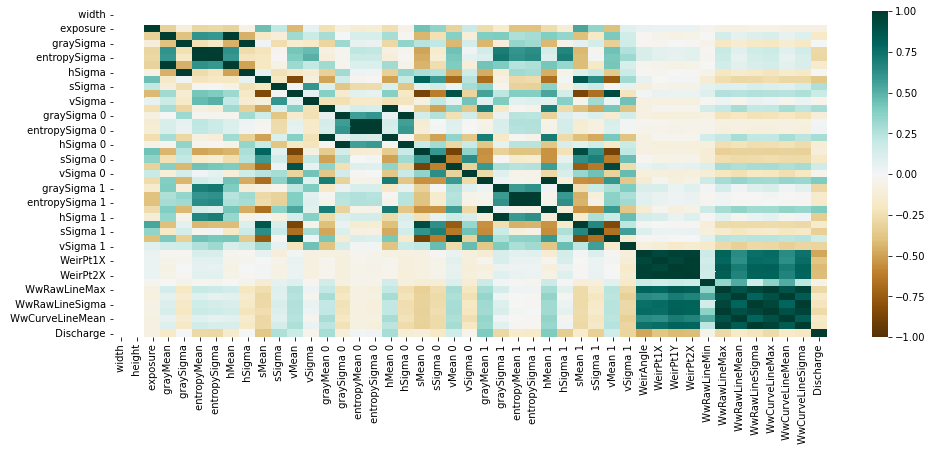

In [ ]:
winter = pd.concat([winter_Xtrain, winter_Ytrain], axis=1)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(winter.corr(), vmin=-1, vmax=1, cmap='BrBG')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Text(0.5, 1.0, 'Spearman correlation')

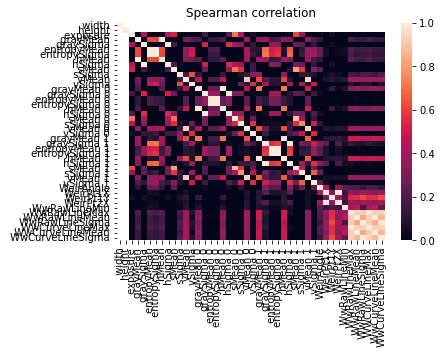

In [ ]:
nvar = winter_Xtrain.columns.size
corr = winter_Xtrain.corr()
cov = winter_Xtrain.cov(ddof=1)

rho_pval = np.zeros((nvar, nvar))
rho = np.eye(nvar)

for i in range(nvar):
    for j in range(i+1, nvar):
        r = spearmanr(winter_Xtrain.iloc[:, i], winter_Xtrain.iloc[:, j])
        rho[i, j] = r[0]
        rho[j, i] = r[0]
        
        rho_pval[i, j] = r[1]
        rho_pval[j, i] = r[1]

sns.heatmap(rho, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0, vmax=1)
plt.title("Spearman correlation")

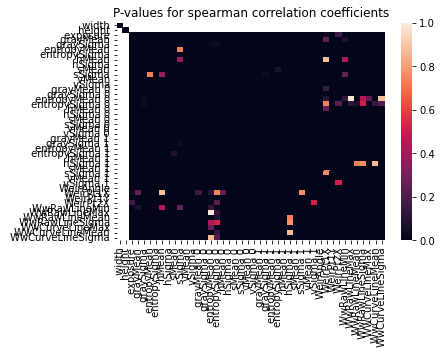

In [ ]:
plt.title("P-values for spearman correlation coefficients")
sns.heatmap(rho_pval, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0, vmax=1)

In [ ]:
det = LA.det(cov)
det

0.0

### PCA

In [ ]:
pca = PCA(n_components = nvar)
pca.fit(winter_Xtrain)

PCA(n_components=44)

Varianza explicada acumulada:
 [0.27802931 0.45589612 0.59631991 0.69249894 0.75541449 0.79918572
 0.83288104 0.85977135 0.88146397 0.8996249  0.91357449 0.92651162
 0.93834999 0.94973869 0.95918877 0.96669573 0.97309259 0.97804614
 0.98250623 0.98656924 0.99060362 0.99335036 0.99518576 0.99647735
 0.99755742 0.99835191 0.99893224 0.99928841 0.99958941 0.99970095
 0.99978498 0.99985002 0.99989436 0.99992642 0.99994728 0.99996425
 0.99997944 0.99998997 0.99999431 0.9999984  0.99999999 1.
 1.         1.        ]


Text(0.5, 1.0, 'Número de componentes vs porcentaje de varianza explicada')

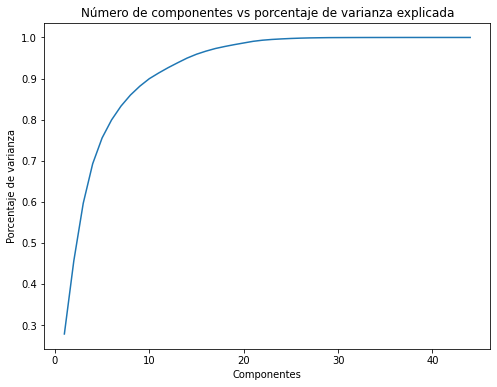

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

print("Varianza explicada acumulada:\n", cumulative_variance)

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 45, 1), cumulative_variance)
plt.xlabel("Componentes")
plt.ylabel("Porcentaje de varianza")
plt.title("Número de componentes vs porcentaje de varianza explicada")

In [ ]:
# pca = PCA(n_components = 20)
# pca.fit(xnew)

# scores = pca.transform(xnew)

## Models

### Linear Regression

In [50]:
modeLr = LinearRegression()
resLr = modeLr.fit(winter_Xtrain, winter_Ytrain)

In [51]:
y_pred = resLr.predict(winter_Xtest)
res = winter_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(winter_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(winter_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(winter_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(winter_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  2056335.6655546962
RSMSE:  1433.9929098690468
MAE:  839.5650984153505
Error estandar:  1390.8540131850573


### Ridge Regression

In [52]:
ridgeMod = Ridge(alpha=1.0)
resRid = ridgeMod.fit(winter_Xtrain, winter_Ytrain)

In [53]:
y_pred = resRid.predict(winter_Xtest)
res = winter_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(winter_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(winter_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(winter_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(winter_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  527432.1676156112
RSMSE:  726.2452530761294
MAE:  537.5399948105946
Error estandar:  636.5729263374828


### Lasso Regression

In [54]:
lassoMod = Lasso(alpha=1.0)
resLasso = lassoMod.fit(winter_Xtrain, winter_Ytrain)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+08, tolerance: 5.105e+06
  model = cd_fast.enet_coordinate_descent(


In [55]:
y_pred = resLasso.predict(winter_Xtest)
res = winter_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(winter_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(winter_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(winter_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(winter_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  512450.7854377941
RSMSE:  715.8566793973456
MAE:  541.847354591589
Error estandar:  624.6921762568376


### Knn

In [56]:
kMod = KNeighborsRegressor(n_neighbors=75)
resK = kMod.fit(winter_Xtrain, winter_Ytrain)

In [57]:
y_pred = resK.predict(winter_Xtest)
res = winter_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(winter_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(winter_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(winter_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(winter_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  393780.76821470464
RSMSE:  627.5195361219479
MAE:  350.5308620571658
Error estandar:  590.3670132586354


### Decision Tree

In [58]:
dTreeMod = DecisionTreeRegressor(random_state=0)
resTree = dTreeMod.fit(winter_Xtrain, winter_Ytrain)

In [59]:
y_pred = resTree.predict(winter_Xtest)
res = winter_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(winter_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(winter_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(winter_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(winter_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  1015884.1218386474
RSMSE:  1007.9107707722184
MAE:  524.7947871376812
Error estandar:  971.7103837456598


### Random Forest

In [60]:
rForMod = RandomForestRegressor()
rForRes = rForMod.fit(winter_Xtrain, winter_Ytrain)

In [61]:
y_pred = rForRes.predict(winter_Xtest)
res = winter_Ytest.squeeze() - y_pred.squeeze()

print("MSE: ", mse(winter_Ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(winter_Ytest.squeeze(), y_pred))
print("MAE: ", meanabs(winter_Ytest.squeeze(), y_pred))
print("Error estandar: ", stde(winter_Ytest.squeeze(), y_pred, ddof = 3))

MSE:  344460.0787626677
RSMSE:  586.9072147815766
MAE:  357.95246563254824
Error estandar:  535.7620816359268
